<a href="https://colab.research.google.com/github/Vakhranev/Networks/blob/master/%D0%A1%D0%B1%D0%BE%D1%80_ID_%D0%B3%D1%80%D1%83%D0%BF%D0%BF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip3 install vk --user

In [2]:
# !pip install vk_api

In [28]:
import pandas as pd
import csv
import vk_api
import re
import collections
import matplotlib.pyplot as plt

from operator import itemgetter

In [4]:
diacov = pd.read_csv('slovar_edited (2).csv')
len(diacov)

16132

In [5]:
diacov.head()

,(БОНГ)
0,A
1,AAA
2,AM
3,C
4,DVD


Уберём из списка все слова, в которых менее 4 символов

In [6]:
d_list = []
for word in diacov['(БОНГ)']:
    if len(word) > 3:
        d_list.append(word)
len(d_list)

15121

In [7]:
READ = True

In [8]:
if not READ:
    vk_session = vk_api.VkApi(login, password)
    vk_session.auth()

    vk = vk_session.get_api()

Найдём все группы, в которых используются слова из списка

In [9]:
if READ:
    with open("Список ID групп.txt", "r") as file:
        full_list = [line.strip() for line in file.readlines()]
    
else:
    groups_ids = []
    for word in d_list:
        groups_ids.append([g['id'] for g in vk.groups.search(q=word, sort=2)['items']])

    # Теперь соберём в один список все ID групп без повторов
    
    full_list = []
    for ids in groups_ids:
        for id in ids:
            if id in full_list:
                continue
            else:
                full_list.append(id)

In [10]:
# print(len(groups_ids))
# print(groups_ids[:10])
print(len(full_list))
print(len(d_list))

114455
15121


In [11]:
# write results to files

if not READ:
    with open("Список ID групп.txt", "w") as file:
        print(*full_list, file=file, sep="\n")
        
    rows = zip(d_list, groups_ids)

    with open("Слова и группы.csv", "w") as f:
        writer = csv.writer(f)
        for row in rows:
            writer.writerow(row)

In [12]:
# read data

words_and_groups = pd.read_csv('Слова и группы.csv', header=None)
words_and_groups.columns = ['word', 'groups']

for row_id in range(words_and_groups.shape[0]):
    # make lists of groups (not str)
    words_and_groups['groups'][row_id] = \
    [re.sub('[\[\] ]', "", group_id) for group_id in words_and_groups['groups'][row_id].split(',')]
    # remove blank elements
    if '' in words_and_groups['groups'][row_id]:
        words_and_groups['groups'][row_id].remove('') 

In [13]:
words_and_groups.head()

,word,groups
0,EMOM,[76241217]
1,«ДЖЕНЕРАЛ,"[24591951, 44283465, 141995214, 20368056, 1558..."
2,«КОЛЛ,"[160306783, 163767797, 110418645, 90907483, 12..."
3,«КОЛЛ»,"[160306783, 163767797, 110418645, 90907483, 12..."
4,«ЛОНГ»,"[94695077, 61951703, 19947779, 193373963, 3124..."


Take top 7000 groups (according to frequency of using words):

In [14]:
# initialize zero-counts

word_counts = {group_id: 0 for group_id in full_list}

In [15]:
# compute counts

for row_id in range(words_and_groups.shape[0]):
    for group_id in words_and_groups['groups'][row_id]:
        word_counts[group_id] += 1

In [17]:
print(max(word_counts.values()))
print(min(word_counts.values()))

14
1


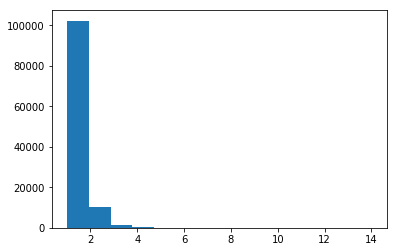

In [31]:
x = list(word_counts.values())
plt.hist(x, bins=14)
plt.show()

In [18]:
# sort dict

word_counts_sorted = collections.OrderedDict((sorted(word_counts.items(), key=itemgetter(1))))

In [19]:
# make list of groups to remove

groups_to_remove = list(word_counts_sorted.keys())[: len(word_counts_sorted) - 5000]
groups_to_remove = set(groups_to_remove)
len(groups_to_remove)

109455

In [20]:
# delete groups from words_and_groups

words_and_groups['groups'] = words_and_groups['groups'].apply(
    lambda x: list(set(x) - groups_to_remove))     

In [22]:
words_and_groups.head()

,word,groups
0,EMOM,[]
1,«ДЖЕНЕРАЛ,"[44283465, 21946972, 133125527, 52770369, 2036..."
2,«КОЛЛ,"[146822877, 90907483, 42448512, 150500858, 456..."
3,«КОЛЛ»,"[146822877, 90907483, 42448512, 150500858, 456..."
4,«ЛОНГ»,"[160189295, 148816134, 167367178, 45733941, 19..."


In [23]:
# delete rows like "word: []"

words_and_groups = words_and_groups.drop(words_and_groups[words_and_groups['groups'].map(len) == 0].index)

In [24]:
words_and_groups.head()

,word,groups
1,«ДЖЕНЕРАЛ,"[44283465, 21946972, 133125527, 52770369, 2036..."
2,«КОЛЛ,"[146822877, 90907483, 42448512, 150500858, 456..."
3,«КОЛЛ»,"[146822877, 90907483, 42448512, 150500858, 456..."
4,«ЛОНГ»,"[160189295, 148816134, 167367178, 45733941, 19..."
5,«МЕДВЕДЕЙ»,[91197755]


In [25]:
len(words_and_groups)

3066

In [26]:
words_and_groups.to_csv('words_and_groups_filtered.csv', index=False)

In [27]:
words_and_groups_filtered = pd.read_csv('words_and_groups_filtered.csv')
words_and_groups_filtered.head()

,word,groups
0,«ДЖЕНЕРАЛ,"['44283465', '21946972', '133125527', '5277036..."
1,«КОЛЛ,"['146822877', '90907483', '42448512', '1505008..."
2,«КОЛЛ»,"['146822877', '90907483', '42448512', '1505008..."
3,«ЛОНГ»,"['160189295', '148816134', '167367178', '45733..."
4,«МЕДВЕДЕЙ»,['91197755']
